In [12]:
import data1 as data
import random
from common import *
from rules import *
from realkd.patch import RuleFit
from sklearn.model_selection import cross_validate, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneOut
import numpy as np
import matplotlib.colors as mcolors


In [2]:
import warnings
warnings.filterwarnings("ignore")

## Full phase prediction


In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.multioutput import ClassifierChain
from multilabel import BinaryRelevanceClassifier, ProbabilisticClassifierChain
from gam import LogisticGAM

STATE = np.random.RandomState(seed=1000)

lr = LogisticRegressionCV(penalty='l1', solver='saga', random_state=STATE)
lr_ind = BinaryRelevanceClassifier(lr)
lr_chain = ClassifierChain(lr, order=[0, 1, 2])
lr_pcc = ProbabilisticClassifierChain(lr) 

# gams not fixed, remove this part.
# gam_ind = BinaryRelevanceClassifier(LogisticGAM(lam=20.0, max_iter=250))
# gam_chain = ClassifierChain(LogisticGAM(lam=20.0, max_iter=250))
# gam_pcc = ProbabilisticClassifierChain(LogisticGAM(lam=20.0, max_iter=250)) 

rf = RandomForestClassifier(random_state=STATE, min_samples_leaf=1, n_estimators=100)
rf_ind = BinaryRelevanceClassifier(rf)
rf_chain = ClassifierChain(rf, order=[0, 2, 1])
rf_pcc = ProbabilisticClassifierChain(rf)

# Rulefit
rufit_pcc = RuleFitWrapper()

indi_estimators = [lr, rf, rufit_pcc]
indi_names = ['LR', 'RF', 'rufit_pcc']

This following code under "2.6 GHz 6-Core Intel Core i7" runs ~5 hours. You can simply use saved result to re-run the result.

In [7]:
from common import Experiment, LogLikelihoodEvaluator
from sklearn.model_selection import KFold
from common import ExtrapolationExperiment, sample_size, GroupDescription
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score

extra_no_comp = {}

for y in [data.sphere, data.vesicle, data.worm]:
    print('Target: ',y.name)
    experiment = ExtrapolationExperiment(indi_estimators, 
                                        indi_names,
                                        data.x, y.replace(-1, 0), data.comp_ids.values,
                                        score=['accuracy', LogLikelihoodEvaluator(2, neg=True), 
                                               sample_size,
                                               GroupDescription(data.comp_descr, 'composition')]).run()

    extra_no_comp[y.name] = experiment.run()
    print()


Target:  sphere
Running experiment with 37 repetitions
*************************************
Running experiment with 37 repetitions
*************************************

Target:  vesicle
Running experiment with 37 repetitions
*************************************
Running experiment with 37 repetitions
*************************************

Target:  worm
Running experiment with 37 repetitions
*************************************
Running experiment with 37 repetitions
*************************************



In [8]:
# import pickle
# # cur_save=open('./' + 'extra_37folder_indi' + '.p', 'rb')
# # extra_no_comp = pickle.load(cur_save)

In [14]:
def plot_summary(metric, summ, num_reps=30, baseline=None, names=None, colors = list(mcolors.BASE_COLORS.keys())):
    width = 0.35
    ind = np.arange(len(summ))
    plt.bar(ind-width/2, summ[f'mean_train_{metric}'], width=width, label='train', 
            yerr=summ[f'std_train_{metric}']/num_reps**0.5, capsize=3.0)
    plt.bar(ind+width/2, summ[f'mean_test_{metric}'], width=width, label='test',
            yerr=summ[f'std_test_{metric}']/num_reps**0.5, capsize=3.0)
    if baseline:
        for i in range(len(baseline)):
            plt.axhline(y=baseline[i], color=colors[i], linestyle='-', label=names[i])
    plt.ylabel(metric)
    plt.legend()
    plt.xticks(ind, summ.index)
    
for key in extra_no_comp:
    df = extra_no_comp[key].summary()
    df['mean_train_error'] = 1- df['mean_train_accuracy']
    df['std_train_error'] = df['std_train_accuracy']
    df['mean_test_error'] = 1- df['mean_test_accuracy']
    df['std_test_error'] = df['std_test_accuracy']
    extra_no_comp[key] = df

In [15]:
# get base line 
# error
informed_error = []
for each in [data.sphere, data.vesicle, data.worm]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    informed_error.append((1-max(prob)))
print('Informed error: ', informed_error)

uniformed_error = [0.5, 0.5, 0.5]
print('Uninformed error: ', uniformed_error)

Informed error:  [0.46283783783783783, 0.2922297297297297, 0.33783783783783783]
Uninformed error:  [0.5, 0.5, 0.5]


In [16]:
extra_no_comp[key] # name is wrong. Should be RuFit not Rufit pcc

,mean_train_accuracy,std_train_accuracy,mean_test_accuracy,std_test_accuracy,mean_train_log loss,std_train_log loss,mean_test_log loss,std_test_log loss,mean_train_size,std_train_size,mean_test_size,std_test_size,mean_train_error,std_train_error,mean_test_error,std_test_error
LR,0.634132,0.016691,0.662511,0.365846,0.837080,0.009232,0.781263,0.376763,576.0,25.69479,16.0,25.69479,0.365868,0.016691,0.337489,0.365846
RF,1.000000,0.000000,0.814256,0.255118,0.078534,0.002129,0.775352,1.477459,576.0,25.69479,16.0,25.69479,0.000000,0.000000,0.185744,0.255118
rufit_pcc,0.987635,0.002950,0.768622,0.294646,0.105359,0.005786,1.134954,1.448602,576.0,25.69479,16.0,25.69479,0.012365,0.002950,0.231378,0.294646


sphere 



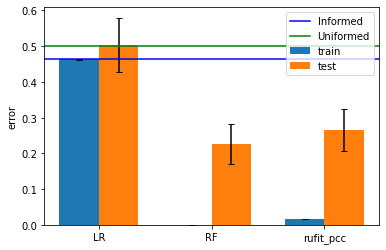

vesicle 



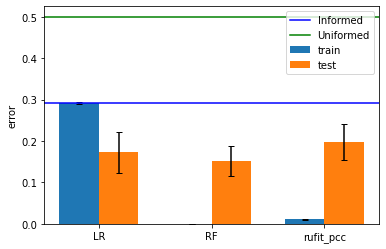

worm 



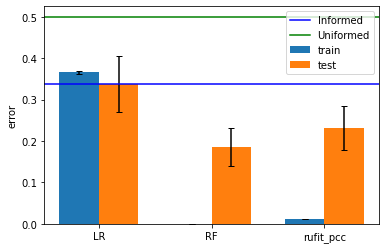

In [17]:
i = 0
for key in extra_no_comp:
    print(key, '\n')
    line = [informed_error[i], uniformed_error[i]]
    plot_summary('error', summ=extra_no_comp[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()

__Log loss__

All the estimators performs much better than random guessing and informed guessing.

In [32]:
# get base line 
# log loss
informed_loglikelihood = []
for each in [data.sphere, data.vesicle, data.worm]:
    uniq, cnt = np.unique(each, return_counts=True)
    prob = cnt/sum(cnt)
    probmax = [max(prob), max(prob)]
    informed_loglikelihood.append(sum(-1*prob * np.log2(prob)))
print('Informed logloss: ', informed_loglikelihood)

uniformed_loglikelihood = [-1*0.5 * np.log2(0.5)*2] * 3
print('Uninformed logloss: ', uniformed_loglikelihood)

Informed logloss:  [0.9960115235485287, 0.8715841441742509, 0.9227346209530941]
Uninformed logloss:  [1.0, 1.0, 1.0]


__Only vesicle is better than the informed guessing__

* Bugs need to fix latter to 1d

sphere 



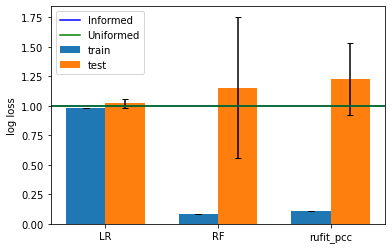

vesicle 



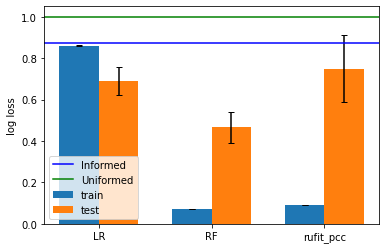

worm 



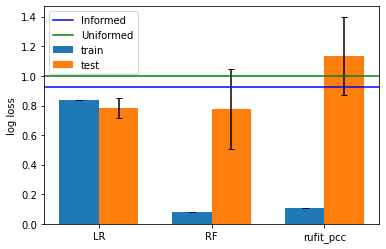

In [33]:
i = 0
for key in extra_no_comp:
    print(key, '\n')
    line = [informed_loglikelihood[i], uniformed_loglikelihood[i]]
    plot_summary('log loss', summ=extra_no_comp[key], baseline=line, names=['Informed', 'Uniformed'])
    i += 1
    plt.show()